# Imports

In [82]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GeometricDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
import re
import gc
import os
from scipy.stats import norm
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
from torch.utils.data import TensorDataset, DataLoader

# Helper Functions

In [83]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Pre-Processing Data

In [84]:
def load_and_preprocess_data(csv_path, chunk_size=1000):
    """Load and preprocess data in chunks to manage memory."""
    features = ['formation_energy_per_atom', 'energy_per_atom', 'density', 'volume', 'n_elements', 'li_fraction']
    target = 'band_gap'
    filtered_chunks = []

    def parse_formula(formula):
        elements = re.findall(r'([A-Z][a-z]?)(\d*)', formula)
        total_atoms = sum(int(n) if n else 1 for _, n in elements)
        li_count = next((int(n) if n else 1 for e, n in elements if e == 'Li'), 0)
        return li_count / total_atoms if total_atoms > 0 else 0

    for chunk in pd.read_csv(csv_path, chunksize=chunk_size):
        chunk['elements'] = chunk['elements'].apply(eval)
        chunk['contains_li'] = chunk['elements'].apply(lambda x: 'Li' in x)
        chunk['li_fraction'] = chunk['formula_pretty'].apply(parse_formula)
        filtered_chunk = chunk[
            (chunk['contains_li']) &
            (chunk['is_semiconductor']) &
            (chunk['band_gap'].between(1, 3)) &
            (chunk['formation_energy_per_atom'] < 0)
        ].copy()
        if not filtered_chunk.empty:
            filtered_chunks.append(filtered_chunk[features + [target, 'elements']])
        del chunk
        gc.collect()
    
    if not filtered_chunks:
        raise ValueError("Filtered dataset is empty.")
    
    filtered_df = pd.concat(filtered_chunks, ignore_index=True)
    X = filtered_df[features].fillna(filtered_df[features].mean()).values
    y = filtered_df[target].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return filtered_df, X_scaled, y, scaler, features

In [85]:
def simple_eda(filtered_df, features, target='band_gap'):
    print("Dataset Shape:", filtered_df.shape)
    print("\nFeature and Target Statistics:")
    print(filtered_df[features + [target]].describe())
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(filtered_df[target], bins=20, kde=True, color='skyblue')
    plt.title('Band Gap Distribution')
    plt.subplot(1, 2, 2)
    corr_matrix = filtered_df[features + [target]].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("\nMissing Values:")
    print(filtered_df[features + [target]].isnull().sum())

In [86]:
def create_graph_data(df, X_scaled, targets=None, batch_size=32):
    data_list = []
    for i in range(len(df)):
        x = torch.tensor(X_scaled[i], dtype=torch.float).reshape(-1, 1)
        num_nodes = x.shape[0]
        edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], 
                                 dtype=torch.long).t().contiguous()
        data = Data(x=x, edge_index=edge_index)
        if targets is not None:
            data.y = torch.tensor([targets[i]], dtype=torch.float)
        data_list.append(data)
        if len(data_list) >= batch_size:
            yield GeometricDataLoader(data_list, batch_size=batch_size, shuffle=False)
            data_list = []
    if data_list:
        yield GeometricDataLoader(data_list, batch_size=len(data_list), shuffle=False)

# Models

In [87]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.fc(x)

In [88]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU())
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, input_dim))

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Training Functions

In [89]:
def train_vae(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch[0].to(device)  
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = vae_loss(recon, batch, mu, logvar)  
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_vae(model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch[0].to(device)
            recon, mu, logvar = model(batch)
            loss = vae_loss(recon, batch, mu, logvar) 
            total_loss += loss.item()
    return total_loss / len(val_loader)

def train_gnn(model, loader_gen, optimizer, device):
    model.train()
    total_loss = 0
    batches = 0
    for loader in loader_gen:
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch).squeeze()
            loss = F.mse_loss(out, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batches += 1
            del batch, out, loss
            torch.cuda.empty_cache()
    return total_loss / batches if batches > 0 else 0

def evaluate_gnn(model, loader_gen, device):
    model.eval()
    total_loss = 0
    predictions, true_values = [], []
    batches = 0
    with torch.no_grad():
        for loader in loader_gen:
            for batch in loader:
                batch = batch.to(device)
                out = model(batch).squeeze()
                loss = F.mse_loss(out, batch.y)
                total_loss += loss.item()
                predictions.extend(out.cpu().numpy())
                true_values.extend(batch.y.cpu().numpy())
                batches += 1
                del batch, out, loss
                torch.cuda.empty_cache()
    return total_loss / batches if batches > 0 else 0, predictions, true_values

# Prediction Functions

In [90]:
def predict_with_uncertainty(model, loader_gen, device, num_samples=20):
    model.train()
    predictions = []
    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
        futures = []
        for loader in loader_gen:
            for batch in loader:
                batch = batch.to(device)
                futures.append(executor.submit(lambda b: [
                    model(b).squeeze().detach().cpu().numpy() for _ in range(num_samples)
                ], batch))
        for future in futures:
            preds = np.stack(future.result(), axis=0)
            mean_preds = np.mean(preds, axis=0)
            std_preds = np.std(preds, axis=0)
            predictions.extend(zip(mean_preds, std_preds))
            del preds
            gc.collect()
    return predictions

def compute_confidence(mean, std, lower=1, upper=3):
    if std == 0:
        return 100.0 if lower <= mean <= upper else 0.0
    prob = norm.cdf(upper, mean, std) - norm.cdf(lower, mean, std)
    return 100 * prob

# Early Stopping

In [91]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Main Function

Dataset Shape: (13212, 8)

Feature and Target Statistics:
       formation_energy_per_atom  energy_per_atom       density        volume  \
count               13212.000000     13212.000000  13212.000000  13212.000000   
mean                   -0.661909         0.041241     -0.284938      0.264427   
std                     0.329247         0.291467      0.608940      0.958892   
min                    -2.068117        -2.478625     -1.572320     -1.165317   
25%                    -0.851633        -0.119552     -0.635320     -0.385148   
50%                    -0.609646         0.009106     -0.420400      0.076739   
75%                    -0.454280         0.166592     -0.137662      0.604885   
max                    -0.000952         1.022740      2.953192      8.222342   

         n_elements   li_fraction      band_gap  
count  13212.000000  13212.000000  13212.000000  
mean       4.083258      0.201929      1.608299  
std        0.715350      0.112442      0.457549  
min        2

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


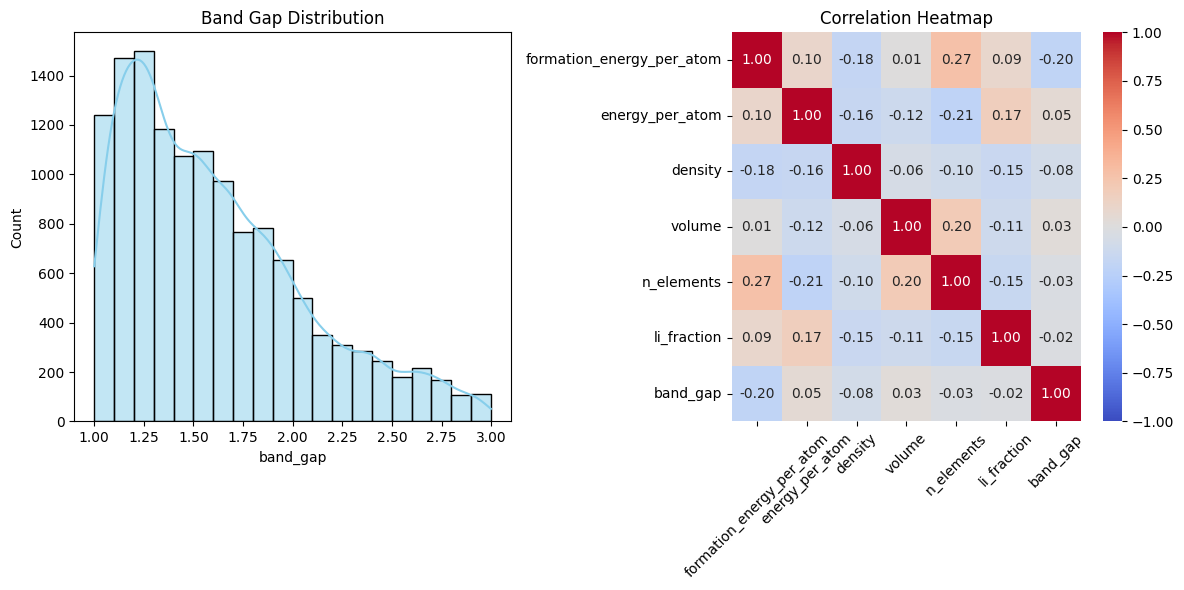


Missing Values:
formation_energy_per_atom    0
energy_per_atom              0
density                      0
volume                       0
n_elements                   0
li_fraction                  0
band_gap                     0
dtype: int64
Epoch 0:
  GNN - Train Loss: 0.5792, Val Loss: 0.2070
  VAE - Train Loss: 183.5727, Val Loss: 165.1681
Epoch 10:
  GNN - Train Loss: 0.0000, Val Loss: 0.0000
  VAE - Train Loss: 147.3012, Val Loss: 144.1118
Epoch 20:
  GNN - Train Loss: 0.0000, Val Loss: 0.0000
  VAE - Train Loss: 141.6193, Val Loss: 139.7192
Epoch 30:
  GNN - Train Loss: 0.0000, Val Loss: 0.0000
  VAE - Train Loss: 140.2622, Val Loss: 136.9395
Epoch 40:
  GNN - Train Loss: 0.0000, Val Loss: 0.0000
  VAE - Train Loss: 138.8175, Val Loss: 137.2332

Sample of Generated Structures:
   formation_energy_per_atom  energy_per_atom   density    volume  n_elements  \
0                  -0.406379        -0.027648 -0.660806  0.129583    5.313307   
1                  -0.816762         0.

  0%|          | 0/5 [00:00<?, ?it/s]

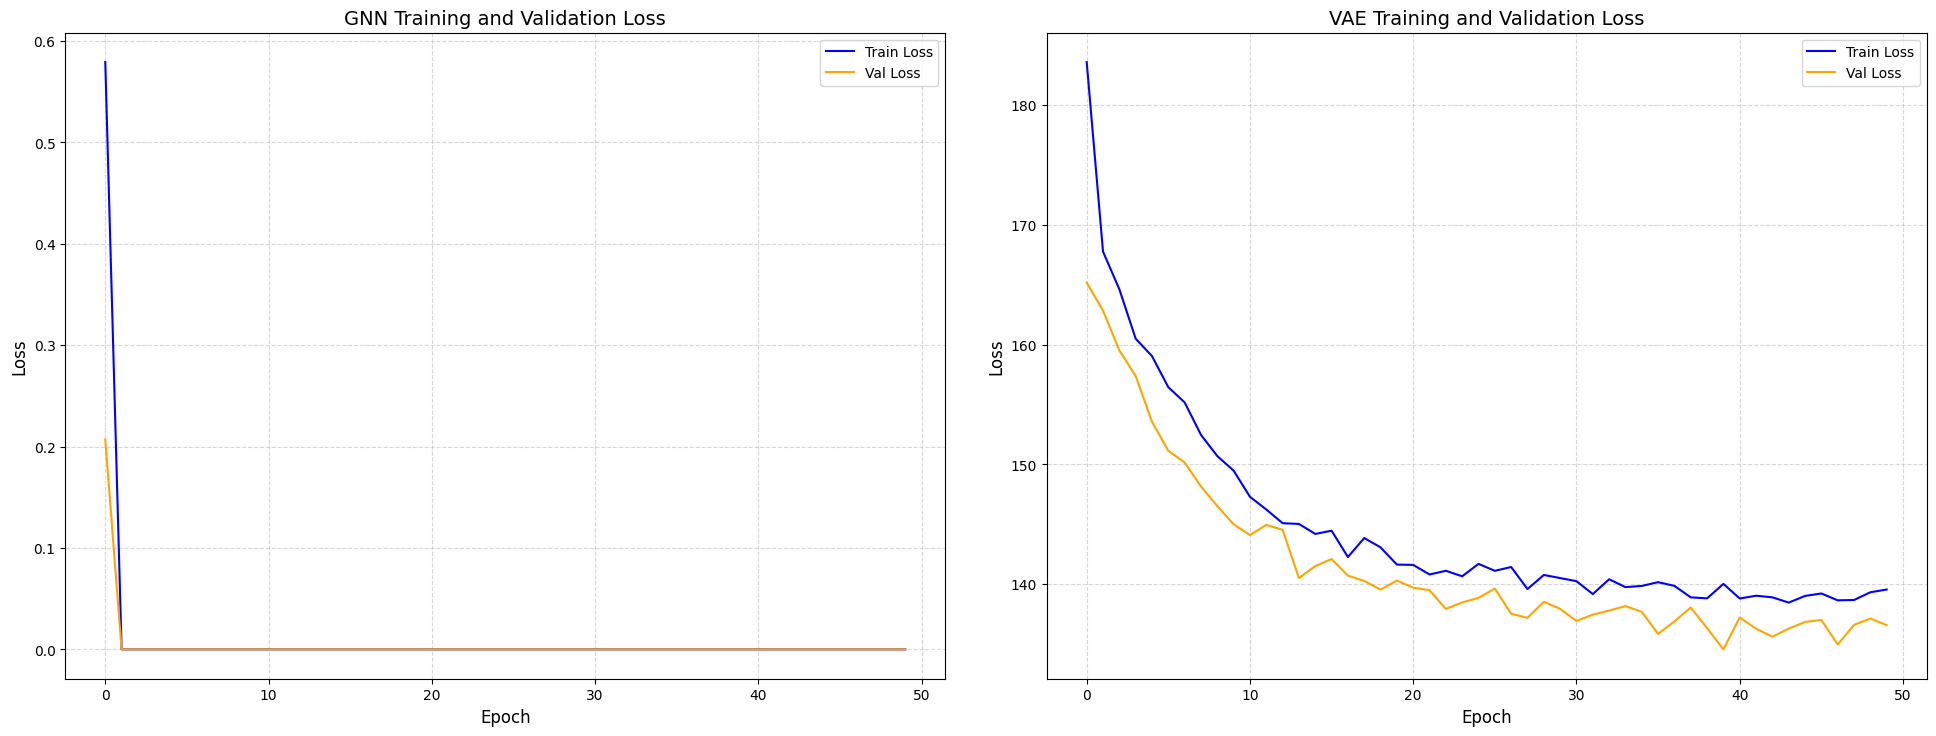

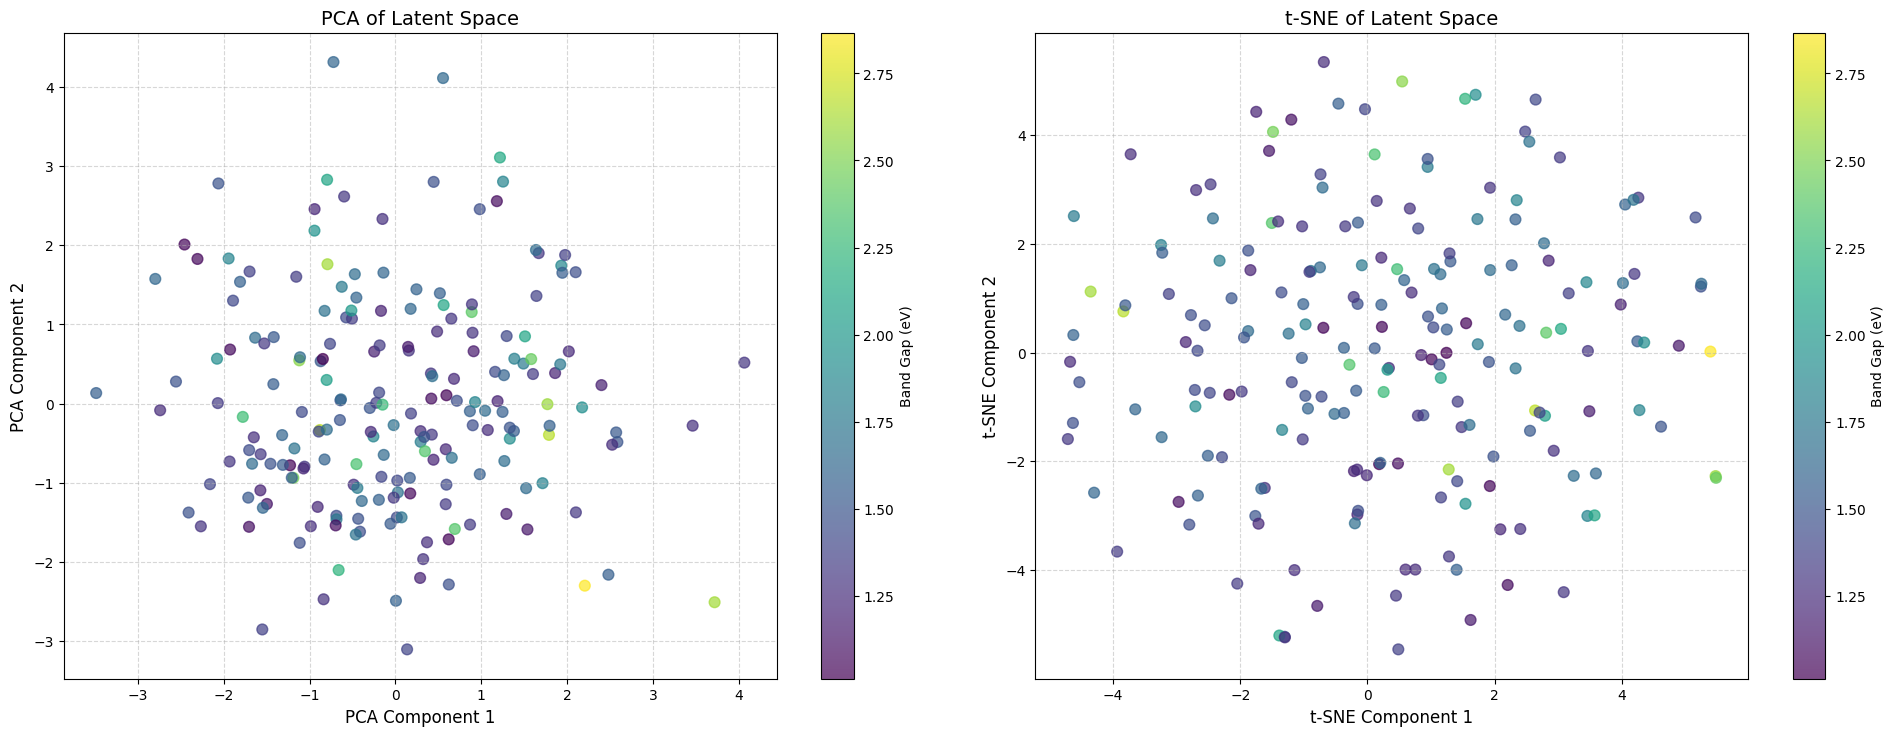

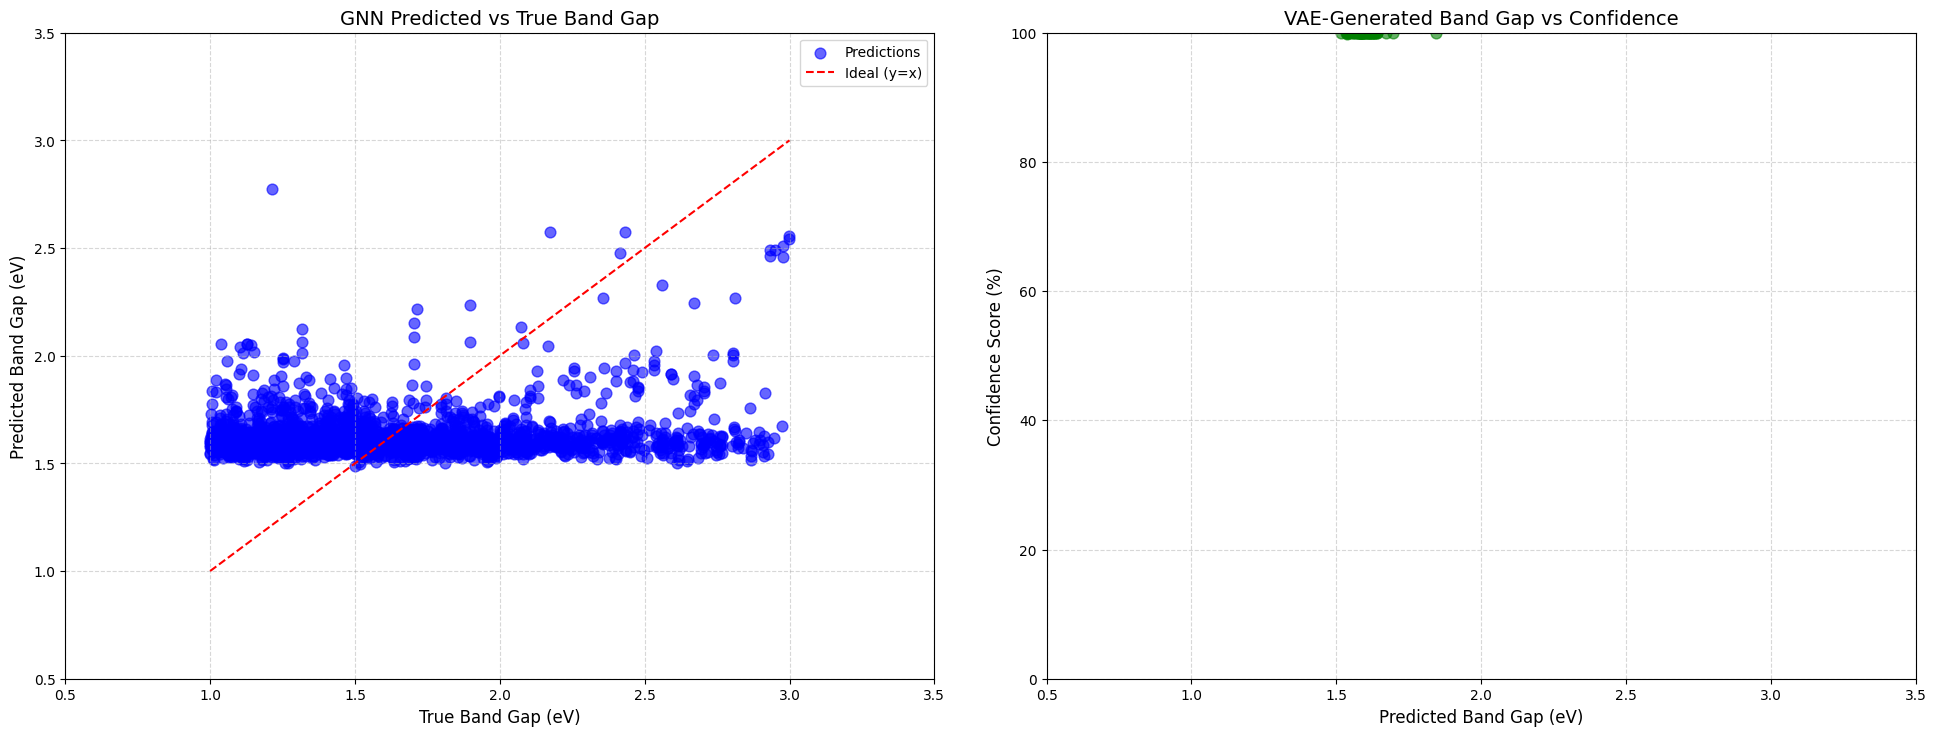

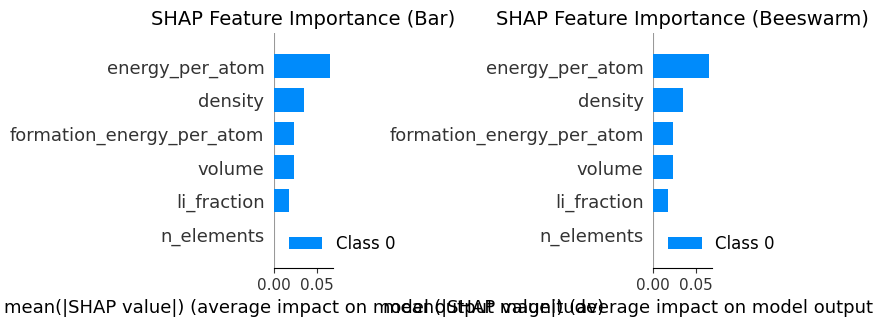


=== Final Report ===
Dataset Size: 13212 samples
GNN Final Training Loss: 0.0000
GNN Final Validation Loss: 0.0000
VAE Final Training Loss: 139.5652
VAE Final Validation Loss: 136.5951

GNN Test Predictions Summary:
  Mean Predicted Band Gap: 1.6253 eV
  Mean Prediction Uncertainty (Std): 0.1373 eV
  Mean Absolute Error: 0.3693 eV

VAE Generated Predictions Summary:
  Mean Generated Band Gap: 1.5983 eV
  Mean Confidence Score: 99.99%


In [96]:
if __name__ == "__main__":
    csv_path = "/kaggle/input/material-science/lithium_battery_materials.csv"  
    filtered_df, X_scaled, y, scaler, features = load_and_preprocess_data(csv_path, chunk_size=1000)
    simple_eda(filtered_df, features)

    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    input_dim = 1  
    hidden_dim = 64
    output_dim = 1  
    vae_input_dim = X_scaled.shape[1]  
    latent_dim = 32
    batch_size = 32

    gnn = GNN(input_dim, hidden_dim, output_dim).to(device)
    vae = VAE(input_dim=vae_input_dim, latent_dim=latent_dim).to(device)

    def vae_loss(recon_x, x, mu, logvar):
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32))
    train_loader_vae = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_vae = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_loader_gen = create_graph_data(filtered_df.iloc[:len(X_train)], X_train, y_train, batch_size=batch_size)
    val_loader_gen = create_graph_data(filtered_df.iloc[len(X_train):len(X_train) + len(X_val)], X_val, y_val, batch_size=batch_size)
    test_loader_gen = create_graph_data(filtered_df.iloc[len(X_train) + len(X_val):], X_test, y_test, batch_size=batch_size)

    optimizer_gnn = optim.Adam(gnn.parameters(), lr=0.001)
    scheduler_gnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_gnn, T_max=50)
    optimizer_vae = optim.Adam(vae.parameters(), lr=0.001)
    scheduler_vae = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_vae, T_max=50)
    early_stopping_gnn = EarlyStopping(patience=10)
    early_stopping_vae = EarlyStopping(patience=10)

    gnn_train_losses, gnn_val_losses = [], []
    vae_train_losses, vae_val_losses = [], []
    max_epochs = 50
    for epoch in range(max_epochs):
        gnn_train_loss = train_gnn(gnn, train_loader_gen, optimizer_gnn, device)
        gnn_val_loss, _, _ = evaluate_gnn(gnn, val_loader_gen, device)
        gnn_train_losses.append(gnn_train_loss)
        gnn_val_losses.append(gnn_val_loss)
        scheduler_gnn.step()

        vae_train_loss = train_vae(vae, train_loader_vae, optimizer_vae, device)
        vae_val_loss = evaluate_vae(vae, val_loader_vae, device)
        vae_train_losses.append(vae_train_loss)
        vae_val_losses.append(vae_val_loss)
        scheduler_vae.step()

        early_stopping_gnn(gnn_val_loss)
        early_stopping_vae(vae_val_loss)

        if gnn_val_loss < float('inf'):
            torch.save(gnn.state_dict(), 'best_gnn_model.pt')
        if vae_val_loss < float('inf'):
            torch.save(vae.state_dict(), 'best_vae_model.pt')

        if epoch % 10 == 0:
            print(f"Epoch {epoch}:")
            print(f"  GNN - Train Loss: {gnn_train_loss:.4f}, Val Loss: {gnn_val_loss:.4f}")
            print(f"  VAE - Train Loss: {vae_train_loss:.4f}, Val Loss: {vae_val_loss:.4f}")

        if early_stopping_gnn.early_stop and early_stopping_vae.early_stop:
            print(f"Early stopping at epoch {epoch} for both GNN and VAE")
            break

        gc.collect()

    gnn.load_state_dict(torch.load('best_gnn_model.pt', weights_only=True))
    vae.load_state_dict(torch.load('best_vae_model.pt', weights_only=True))

    num_samples = 50
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_scaled = vae.decoder(z).cpu().numpy()
    generated_original = scaler.inverse_transform(generated_scaled)
    new_df = pd.DataFrame(generated_original, columns=features)
    new_df['predicted_band_gap'] = 0.0
    new_df['confidence_score'] = 0.0

    generated_loader_gen = create_graph_data(new_df, generated_scaled, batch_size=batch_size)
    generated_predictions = predict_with_uncertainty(gnn, generated_loader_gen, device)
    gen_means = np.array([mean for mean, _ in generated_predictions])
    gen_confidences = np.array([compute_confidence(mean, std) for mean, std in generated_predictions])
    for i, (mean, _) in enumerate(generated_predictions):
        new_df.loc[i, 'predicted_band_gap'] = mean
        new_df.loc[i, 'confidence_score'] = gen_confidences[i]
    print("\nSample of Generated Structures:")
    print(new_df.head())
    new_df.to_csv('generated_structures.csv', index=False)

    test_predictions = predict_with_uncertainty(gnn, test_loader_gen, device)
    test_pred_means = np.array([mean for mean, _ in test_predictions])
    test_pred_stds = np.array([std for _, std in test_predictions])

    test_pred_means = np.where(np.isinf(test_pred_means), np.nan, test_pred_means)
    test_pred_stds = np.where(np.isinf(test_pred_stds), np.nan, test_pred_stds)
    y_test = np.where(np.isinf(y_test), np.nan, y_test)
    gen_means = np.where(np.isinf(gen_means), np.nan, gen_means)
    gen_confidences = np.where(np.isinf(gen_confidences), np.nan, gen_confidences)

    X_subset = X_scaled[:200]
    X_tensor = torch.tensor(X_subset, dtype=torch.float32)
    latent_dataset = TensorDataset(X_tensor)
    latent_loader = DataLoader(latent_dataset, batch_size=batch_size, shuffle=False)
    latent = []
    with torch.no_grad():
        for batch in latent_loader:
            batch = batch[0].to(device)
            mu, logvar = vae.encode(batch)
            z = vae.reparameterize(mu, logvar).cpu().numpy()
            latent.append(z)
    latent = np.concatenate(latent, axis=0)
    latent = np.where(np.isinf(latent), np.nan, latent)  

    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent)
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent)

    def gnn_predict(features):
        if len(features.shape) == 1:
            features = features.reshape(1, -1)
        num_graphs = features.shape[0]
        data_list = []
        for i in range(num_graphs):
            x = torch.tensor(features[i], dtype=torch.float32).to(device).reshape(-1, 1)
            num_nodes = x.shape[0]
            edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], 
                                      dtype=torch.long).t().contiguous().to(device)
            data = Data(x=x, edge_index=edge_index)
            data_list.append(data)
        loader = GeometricDataLoader(data_list, batch_size=1, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)
                out = gnn(batch).cpu().numpy()
                preds.append(out)
        return np.concatenate(preds, axis=0)

    background = X_scaled[:50]
    explainer = shap.KernelExplainer(gnn_predict, background)
    shap_values = explainer.shap_values(X_scaled[:5], nsamples=50)

    fig1, axs1 = plt.subplots(1, 2, figsize=(20, 8))
    axs1[0].plot(gnn_train_losses, label='Train Loss', color='blue')
    axs1[0].plot(gnn_val_losses, label='Val Loss', color='orange')
    axs1[0].set_title('GNN Training and Validation Loss', fontsize=14)
    axs1[0].set_xlabel('Epoch', fontsize=12)
    axs1[0].set_ylabel('Loss', fontsize=12)
    axs1[0].legend(fontsize=10)
    axs1[0].grid(True, linestyle='--', alpha=0.5)

    axs1[1].plot(vae_train_losses, label='Train Loss', color='blue')
    axs1[1].plot(vae_val_losses, label='Val Loss', color='orange')
    axs1[1].set_title('VAE Training and Validation Loss', fontsize=14)
    axs1[1].set_xlabel('Epoch', fontsize=12)
    axs1[1].set_ylabel('Loss', fontsize=12)
    axs1[1].legend(fontsize=10)
    axs1[1].grid(True, linestyle='--', alpha=0.5)

    fig1.tight_layout(pad=3.0)
    plt.show()

    fig2, axs2 = plt.subplots(1, 2, figsize=(20, 8))
    scatter_pca = axs2[0].scatter(latent_pca[:, 0], latent_pca[:, 1], c=y[:200], cmap='viridis', alpha=0.7, s=60)
    axs2[0].set_title('PCA of Latent Space', fontsize=14)
    axs2[0].set_xlabel('PCA Component 1', fontsize=12)
    axs2[0].set_ylabel('PCA Component 2', fontsize=12)
    axs2[0].grid(True, linestyle='--', alpha=0.5)
    fig2.colorbar(scatter_pca, ax=axs2[0], label='Band Gap (eV)')

    scatter_tsne = axs2[1].scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=y[:200], cmap='viridis', alpha=0.7, s=60)
    axs2[1].set_title('t-SNE of Latent Space', fontsize=14)
    axs2[1].set_xlabel('t-SNE Component 1', fontsize=12)
    axs2[1].set_ylabel('t-SNE Component 2', fontsize=12)
    axs2[1].grid(True, linestyle='--', alpha=0.5)
    fig2.colorbar(scatter_tsne, ax=axs2[1], label='Band Gap (eV)')

    fig2.tight_layout(pad=3.0)
    plt.show()

    fig3, axs3 = plt.subplots(1, 2, figsize=(20, 8))
    axs3[0].scatter(y_test, test_pred_means, c='blue', alpha=0.6, s=60, label='Predictions')
    axs3[0].plot([1, 3], [1, 3], 'r--', label='Ideal (y=x)')
    axs3[0].set_title('GNN Predicted vs True Band Gap', fontsize=14)
    axs3[0].set_xlabel('True Band Gap (eV)', fontsize=12)
    axs3[0].set_ylabel('Predicted Band Gap (eV)', fontsize=12)
    axs3[0].set_xlim(0.5, 3.5)
    axs3[0].set_ylim(0.5, 3.5)
    axs3[0].grid(True, linestyle='--', alpha=0.5)
    axs3[0].legend(fontsize=10)

    axs3[1].scatter(gen_means, gen_confidences, c='green', alpha=0.6, s=60)
    axs3[1].set_title('VAE-Generated Band Gap vs Confidence', fontsize=14)
    axs3[1].set_xlabel('Predicted Band Gap (eV)', fontsize=12)
    axs3[1].set_ylabel('Confidence Score (%)', fontsize=12)
    axs3[1].set_xlim(0.5, 3.5)
    axs3[1].set_ylim(0, 100)
    axs3[1].grid(True, linestyle='--', alpha=0.5)

    fig3.tight_layout(pad=3.0)
    plt.show()

    fig4, axs4 = plt.subplots(1, 2, figsize=(20, 8))
    plt.sca(axs4[0])
    shap.summary_plot(shap_values, features=features, plot_type="bar", show=False)
    axs4[0].set_title('SHAP Feature Importance (Bar)', fontsize=14)

    plt.sca(axs4[1])
    shap.summary_plot(shap_values, X_scaled[:5], feature_names=features, show=False)
    axs4[1].set_title('SHAP Feature Importance (Beeswarm)', fontsize=14)

    fig4.tight_layout(pad=3.0)
    plt.show()

    print("\n=== Final Report ===")
    print(f"Dataset Size: {len(X_scaled)} samples")
    print(f"GNN Final Training Loss: {gnn_train_losses[-1]:.4f}")
    print(f"GNN Final Validation Loss: {gnn_val_losses[-1]:.4f}")
    print(f"VAE Final Training Loss: {vae_train_losses[-1]:.4f}")
    print(f"VAE Final Validation Loss: {vae_val_losses[-1]:.4f}")
    print("\nGNN Test Predictions Summary:")
    print(f"  Mean Predicted Band Gap: {np.nanmean(test_pred_means):.4f} eV")
    print(f"  Mean Prediction Uncertainty (Std): {np.nanmean(test_pred_stds):.4f} eV")
    print(f"  Mean Absolute Error: {np.nanmean(np.abs(test_pred_means - y_test)):.4f} eV")
    print("\nVAE Generated Predictions Summary:")
    print(f"  Mean Generated Band Gap: {np.nanmean(gen_means):.4f} eV")
    print(f"  Mean Confidence Score: {np.nanmean(gen_confidences):.2f}%")
    print("====================")

    gc.collect()
    torch.cuda.empty_cache()